<a href="https://colab.research.google.com/github/UmarBalak/AdaptFL/blob/main/AdaptFL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
import h5py
import io

# Load HDF5 file from a URL
def load_hdf5_from_url(url, number_of_episodes=1):
    hdf5_files = []
    for episode_number in range(number_of_episodes):
      new_url = url + f'episode_{episode_number}.hdf5'
      response = requests.get(new_url)
      response.raise_for_status()  # Raise an error for bad responses
      hdf5_files.append(h5py.File(io.BytesIO(response.content), 'r'))
      print(f"episode_{episode_number}.hdf5 loaded successfully.")
    return hdf5_files

hdf5_url = 'https://huggingface.co/datasets/nightmare-nectarine/segmentation-carla-driving/resolve/main/train/'
hdf5_files = load_hdf5_from_url(hdf5_url, 6)


episode_0.hdf5 loaded successfully.
episode_1.hdf5 loaded successfully.
episode_2.hdf5 loaded successfully.
episode_3.hdf5 loaded successfully.
episode_4.hdf5 loaded successfully.
episode_5.hdf5 loaded successfully.


In [3]:
# Explore the HDF5 file structure to see what datasets are present
def explore_hdf5_structure(hdf5_file):
    """
    Print the structure and contents of an HDF5 file to explore available datasets.
    """
    def print_structure(name, obj):
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, Shape: {obj.shape}, Type: {obj.dtype}")

    hdf5_file.visititems(print_structure)

# Check each episode file's structure
for episode_file in hdf5_files:
    print("Exploring HDF5 structure:")
    explore_hdf5_structure(episode_file)


Exploring HDF5 structure:
Dataset: controls, Shape: (1419, 3), Type: float64
Dataset: frame, Shape: (1419, 1), Type: int64
Dataset: hlc, Shape: (1419, 1), Type: int64
Dataset: light, Shape: (1419, 1), Type: int64
Dataset: measurements, Shape: (1419, 1), Type: float64
Dataset: rgb, Shape: (1419, 200, 288, 3), Type: uint8
Dataset: segmentation, Shape: (1419, 200, 288, 3), Type: uint8
Exploring HDF5 structure:
Dataset: controls, Shape: (1330, 3), Type: float64
Dataset: frame, Shape: (1330, 1), Type: int64
Dataset: hlc, Shape: (1330, 1), Type: int64
Dataset: light, Shape: (1330, 1), Type: int64
Dataset: measurements, Shape: (1330, 1), Type: float64
Dataset: rgb, Shape: (1330, 200, 288, 3), Type: uint8
Dataset: segmentation, Shape: (1330, 200, 288, 3), Type: uint8
Exploring HDF5 structure:
Dataset: controls, Shape: (2439, 3), Type: float64
Dataset: frame, Shape: (2439, 1), Type: int64
Dataset: hlc, Shape: (2439, 1), Type: int64
Dataset: light, Shape: (2439, 1), Type: int64
Dataset: measurem

In [4]:
import numpy as np
import cv2

def preprocess_rgb_images(hdf5_files, image_size=(128, 128)):
    """
    Preprocess multiple HDF5 files containing RGB images by normalizing and resizing them.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'rgb' dataset.
    - image_size: Target size for resizing the images.

    Returns:
    - rgb_images_combined: Combined and preprocessed RGB images from all episodes.
    """
    rgb_images_combined = []

    # Loop through each HDF5 file and process the RGB images
    for hdf5_file in hdf5_files:
        rgb_images = hdf5_file['rgb'][:]

        # Normalize RGB images
        rgb_images = rgb_images.astype(np.float32) / 255.0

        # Resize images
        rgb_images_resized = np.array([cv2.resize(img, image_size) for img in rgb_images])

        # Append to combined list
        rgb_images_combined.append(rgb_images_resized)

    # Concatenate all episodes into a single dataset
    rgb_images_combined = np.concatenate(rgb_images_combined, axis=0)

    return rgb_images_combined


def preprocess_segmentation_masks(hdf5_files, image_size=(128, 128)):
    """
    Preprocess multiple HDF5 files containing segmentation masks by resizing them.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'segmentation' dataset.
    - image_size: Target size for resizing the masks.

    Returns:
    - segmentation_masks_combined: Combined and preprocessed segmentation masks from all episodes.
    """
    segmentation_masks_combined = []

    # Loop through each HDF5 file and process the segmentation masks
    for hdf5_file in hdf5_files:
        segmentation_masks = hdf5_file['segmentation'][:]

        # Resize masks
        segmentation_masks_resized = np.array([cv2.resize(mask, image_size) for mask in segmentation_masks])

        # Append to combined list
        segmentation_masks_combined.append(segmentation_masks_resized)

    # Concatenate all episodes into a single dataset
    segmentation_masks_combined = np.concatenate(segmentation_masks_combined, axis=0)

    return segmentation_masks_combined

import numpy as np

def preprocess_controls_multiple_episodes(hdf5_files):
    """
    Preprocess control data from multiple HDF5 files by concatenating and normalizing the controls.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'controls' dataset.

    Returns:
    - controls_normalized: Combined and normalized control data from all episodes.
    """
    controls_combined = []

    # Loop through each HDF5 file and concatenate the controls data
    for hdf5_file in hdf5_files:
        controls = hdf5_file['controls'][:]
        controls_combined.append(controls)

    # Concatenate all episodes' controls data
    controls_combined = np.concatenate(controls_combined, axis=0)

    # Normalize controls based on the max absolute value per feature
    controls_normalized = controls_combined / np.max(np.abs(controls_combined), axis=0)

    return controls_normalized

def preprocess_frames_multiple_episodes(hdf5_files):
    """
    Preprocess frame data from multiple HDF5 files by concatenating the frames.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'frame' dataset.

    Returns:
    - frames_combined: Combined frame data from all episodes.
    """
    frames_combined = []

    for hdf5_file in hdf5_files:
        frames = hdf5_file['frame'][:]
        frames_combined.append(frames)

    frames_combined = np.concatenate(frames_combined, axis=0)
    return frames_combined


def preprocess_hlc_multiple_episodes(hdf5_files):
    """
    Preprocess high-level command (hlc) data from multiple HDF5 files by concatenating the hlc data.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'hlc' dataset.

    Returns:
    - hlc_combined: Combined hlc data from all episodes.
    """
    hlc_combined = []

    for hdf5_file in hdf5_files:
        hlc = hdf5_file['hlc'][:]
        hlc_combined.append(hlc)

    hlc_combined = np.concatenate(hlc_combined, axis=0)
    return hlc_combined


def preprocess_light_multiple_episodes(hdf5_files):
    """
    Preprocess light data from multiple HDF5 files by concatenating the light data.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'light' dataset.

    Returns:
    - light_combined: Combined light data from all episodes.
    """
    light_combined = []

    for hdf5_file in hdf5_files:
        light = hdf5_file['light'][:]
        light_combined.append(light)

    light_combined = np.concatenate(light_combined, axis=0)
    return light_combined


def preprocess_measurements_multiple_episodes(hdf5_files):
    """
    Preprocess measurement data from multiple HDF5 files by concatenating the measurements.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'measurements' dataset.

    Returns:
    - measurements_combined: Combined measurement data from all episodes.
    """
    measurements_combined = []

    for hdf5_file in hdf5_files:
        measurements = hdf5_file['measurements'][:]
        measurements_combined.append(measurements)

    measurements_combined = np.concatenate(measurements_combined, axis=0)
    return measurements_combined


# Call the functions
rgb_data = preprocess_rgb_images(hdf5_files)
segmentation_data = preprocess_segmentation_masks(hdf5_files)
controls_normalized = preprocess_controls_multiple_episodes(hdf5_files)
frame_data = preprocess_frames_multiple_episodes(hdf5_files)
hlc_data = preprocess_hlc_multiple_episodes(hdf5_files)
light_data = preprocess_light_multiple_episodes(hdf5_files)
measurements_data = preprocess_measurements_multiple_episodes(hdf5_files)

# Output shapes for verification
print(f"RGB images shape: {rgb_data.shape}")
print(f"Segmentation masks shape: {segmentation_data.shape}")
print(f"Controls shape: {controls_normalized.shape}")
print(f"Frames shape: {frame_data.shape}")
print(f"HLC shape: {hlc_data.shape}")
print(f"Light shape: {light_data.shape}")
print(f"Measurements shape: {measurements_data.shape}")


RGB images shape: (9535, 128, 128, 3)
Segmentation masks shape: (9535, 128, 128, 3)
Controls shape: (9535, 3)
Frames shape: (9535, 1)
HLC shape: (9535, 1)
Light shape: (9535, 1)
Measurements shape: (9535, 1)


In [5]:
def split_data_for_models_multiple_types(data_dict, num_models, data_distribution, data_types=None, random_seed=None):
    """
    Split the preprocessed data into subsets for local models based on the specified distribution.

    Parameters:
    - data_dict: Dictionary containing various preprocessed data types (X, y, etc.).
    - num_models: Number of local models to be implemented.
    - data_distribution: List of proportions for each model's training data.
    - data_types: List of data types to include in the split. If None, all data types are used.
    - random_seed: Seed for reproducibility of data splits.

    Returns:
    - model_data: Dictionary containing training data for each model.
    """

    # Validate inputs
    if len(data_distribution) != num_models:
        raise ValueError("Length of data_distribution must match num_models.")
    if not np.isclose(np.sum(data_distribution), 1.0):
        raise ValueError("Data distribution must sum to 1.")

    # Set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)

    model_data = {}
    total_samples = len(data_dict['rgb'])  # Assumes all data types have the same length

    # If data_types is None, use all keys from data_dict
    if data_types is None:
        data_types = data_dict.keys()

    # Validate that all data types have the same number of samples
    for key in data_types:
        if key in data_dict and len(data_dict[key]) != total_samples:
            raise ValueError(f"Data type '{key}' has inconsistent sample size.")

    indices = np.arange(total_samples)
    np.random.shuffle(indices)  # Shuffle indices for randomness

    start_idx = 0
    for model_id in range(num_models):
        # Calculate the number of samples for the current model
        num_samples = int(data_distribution[model_id] * total_samples)
        if model_id == num_models - 1:  # Last model gets any leftover data
            num_samples = total_samples - start_idx

        model_data[f'model_{model_id + 1}'] = {
            key: np.array([data_dict[key][i] for i in indices[start_idx:start_idx + num_samples]])
            for key in data_types if key in data_dict
        }

        start_idx += num_samples

    return model_data

In [6]:
data_dict = {
    'controls': controls_normalized,
    'frame': frame_data,
    'hlc': hlc_data,
    'light': light_data,
    'measurements': measurements_data,
    'rgb': rgb_data,
    'segmentation': segmentation_data,
}

# Specify the number of local models, data distribution, and types to include
num_local_models = 3
data_distribution = [0.4, 0.4, 0.2]
data_types_to_include = ['rgb', 'segmentation', 'hlc', 'light', 'measurements', 'controls', 'frame']

# Split the data for selected types
model_data = split_data_for_models_multiple_types(data_dict, num_local_models, data_distribution, data_types=data_types_to_include, random_seed=42)

# Output shapes for verification
for model_id, data in model_data.items():
    print(f"{model_id} - Data shapes:")
    for key, value in data.items():
        print(f"  {key}: {value.shape}")

model_1 - Data shapes:
  rgb: (3814, 128, 128, 3)
  segmentation: (3814, 128, 128, 3)
  hlc: (3814, 1)
  light: (3814, 1)
  measurements: (3814, 1)
  controls: (3814, 3)
  frame: (3814, 1)
model_2 - Data shapes:
  rgb: (3814, 128, 128, 3)
  segmentation: (3814, 128, 128, 3)
  hlc: (3814, 1)
  light: (3814, 1)
  measurements: (3814, 1)
  controls: (3814, 3)
  frame: (3814, 1)
model_3 - Data shapes:
  rgb: (1907, 128, 128, 3)
  segmentation: (1907, 128, 128, 3)
  hlc: (1907, 1)
  light: (1907, 1)
  measurements: (1907, 1)
  controls: (1907, 3)
  frame: (1907, 1)


In [7]:
import tensorflow as tf
import keras
from keras import layers, Model, Input

# Defining the model architecture
def create_model(input_shapes):
    """
    Create a multi-input model based on the shapes of the input data.

    Parameters:
    - input_shapes: Dictionary containing the shape of each input type (e.g., 'rgb', 'segmentation', etc.)

    Returns:
    - A compiled Keras model with multiple inputs.
    """
    # Input layers for each type of data
    rgb_input = Input(shape=input_shapes['rgb'], name='rgb_input')
    seg_input = Input(shape=input_shapes['segmentation'], name='seg_input')
    hlc_input = Input(shape=input_shapes['hlc'], name='hlc_input')
    light_input = Input(shape=input_shapes['light'], name='light_input')
    measurements_input = Input(shape=input_shapes['measurements'], name='measurements_input')

    # Simple CNN for RGB and Segmentation inputs
    rgb_features = layers.Conv2D(32, (3, 3), activation='relu')(rgb_input)
    rgb_features = layers.MaxPooling2D((2, 2))(rgb_features)
    rgb_features = layers.Flatten()(rgb_features)

    seg_features = layers.Conv2D(32, (3, 3), activation='relu')(seg_input)
    seg_features = layers.MaxPooling2D((2, 2))(seg_features)
    seg_features = layers.Flatten()(seg_features)

    # Dense layers for other inputs
    hlc_features = layers.Dense(16, activation='relu')(hlc_input)
    light_features = layers.Dense(16, activation='relu')(light_input)
    measurements_features = layers.Dense(16, activation='relu')(measurements_input)

    # Concatenate all features
    concatenated = layers.concatenate([rgb_features, seg_features, hlc_features, light_features, measurements_features])

    # Output layer (adjust depending on your task, e.g., classification, regression)
    output = layers.Dense(1, activation='sigmoid')(concatenated)

    # Create model
    model = Model(inputs=[rgb_input, seg_input, hlc_input, light_input, measurements_input], outputs=output)

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

In [8]:
local_models = []
for model_id, data in model_data.items():
    print(f"Training {model_id}...")

    # Get the shapes of the inputs
    input_shapes = {key: data[key].shape[1:] for key in data_types_to_include}

    # Create a model for this data
    model = create_model(input_shapes)

    labels = data['controls']  # Shape should be (num_samples, 3)

    model.fit(
        [data['rgb'], data['segmentation'], data['hlc'], data['light'], data['measurements']],
        labels, epochs=10, batch_size=16
    )

    local_models.append(model)
    print(f"{model_id} training complete.\n")

Training model_1...
Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 83s 336ms/step - loss: 0.6976 - mae: 0.7172
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 75s 306ms/step - loss: 0.7072 - mae: 0.7282
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 81s 337ms/step - loss: 0.7089 - mae: 0.7305
Epoch 4/10
 24/239 ━━━━━━━━━━━━━━━━━━━━ 1:01 288ms/step - loss: 0.7152 - mae: 0.7363

KeyboardInterrupt: 

# Testing

In [4]:
import requests
from bs4 import BeautifulSoup
import h5py
from io import BytesIO
import numpy as np
import random
import matplotlib.pyplot as plt

# Base URL where the HDF5 files are located
base_url = 'https://huggingface.co/datasets/nightmare-nectarine/segmentation-carla-driving/tree/main/train/'

# Function to scrape all HDF5 file links from the given page
def get_file_urls(base_url):
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    file_urls = []
    for link in soup.find_all('a'):
        href = link.get('href')
        # Check for links ending with .hdf5 and containing '/blob/' in URL
        if '/blob/' in href and href.endswith('.hdf5'):
            # Construct full file URL (replace 'blob/' with 'resolve/' for direct access)
            file_url = 'https://huggingface.co' + href.replace('/blob/', '/resolve/')
            file_urls.append(file_url)  # Append modified URL
    return file_urls

# List to store tuples of (HLC value, RGB image)
hlc_rgb_data = []

# Get all file URLs from the page
file_urls = get_file_urls(base_url)

num_files_to_pick = 5
if num_files_to_pick > len(file_urls):
    print(f"Requested {num_files_to_pick} files, but only {len(file_urls)} are available.")
    num_files_to_pick = len(file_urls)

# Randomly select files
random_files = random.sample(file_urls, num_files_to_pick)

for url in random_files:
    # Download the file
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Validate if the content is in HDF5 format
        try:
            with h5py.File(BytesIO(response.content), 'r') as f:
                # Access the datasets
                hlc_data = f['hlc'][:]
                rgb_data = f['rgb'][:]  # Assuming 'rgb' contains the images

                # Store HLC and corresponding RGB images in the list
                for i in range(len(hlc_data)):
                    hlc_value = hlc_data[i].item()  # Convert numpy int to Python int
                    rgb_image = rgb_data[i]
                    hlc_rgb_data.append((hlc_value, rgb_image))  # Append as a tuple

        except Exception as e:
            print(f"Error processing {url}: {e}")
    else:
        print(f"Failed to download {url}: {response.status_code}")



Displaying 20 images for the specified HLC values.


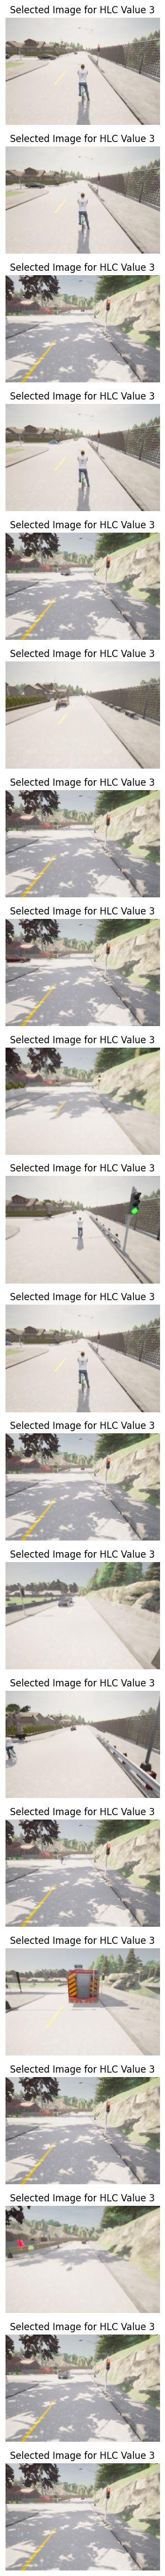

In [7]:
# Specify the HLC values you are interested in
desired_hlc_values = [3]

# Randomly select up to 5 images for the specified HLC values
selected_images = []
selected_hlc_values = []  # To keep track of which HLC values correspond to selected images

for hlc in desired_hlc_values:
    images = [img for value, img in hlc_rgb_data if value == hlc]

    if images:
        # Randomly select up to 5 images for the current HLC value
        sampled_images = random.sample(images, min(20, len(images)))
        selected_images.extend(sampled_images)
        selected_hlc_values.extend([hlc] * len(sampled_images))  # Append the HLC value for each selected image

# Display selected images (up to 5)
if selected_images:
    print(f"Displaying {len(selected_images)} images for the specified HLC values.")
    plt.figure(figsize=(15, len(selected_images) * 3))
    for idx, (image, hlc) in enumerate(zip(selected_images, selected_hlc_values)):
        plt.subplot(len(selected_images), 1, idx + 1)
        plt.imshow(image)
        plt.title(f"Selected Image for HLC Value {hlc}")
        plt.axis('off')
    plt.show()
else:
    print("No images found for the specified HLC values.")